In [1]:
import sys, os
import torch
from torchvision.models import resnet50
import torch
from torch.utils.data.sampler import RandomSampler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import softmax
import math
import collections

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)

from models.CropTypeClassifier import *
from datasets import dataset_utils
from datasets import sequence_aggregator

num_classes = 12

model_path = "C:/Users/results/{}_classes/original_sequences/right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/best_model.pth".format(num_classes)

dataset_folder = "C:/Users/datasets/BavarianCrops/"
class_mapping = os.path.join(dataset_folder, "classmapping{}.csv".format(num_classes))
_, _, test_set = dataset_utils.get_partitioned_dataset(
    dataset_folder,
    class_mapping,
    sequence_aggregator.SequencePadder(),
    None)

test_data_loader = torch.utils.data.DataLoader(
        dataset=test_set,
        sampler=RandomSampler(test_set),
        batch_size=1,
        num_workers=1)

crop_type_classifier_model = init_model_with_hyper_params(
        sequence_length = int(144),
        num_classes = 12,
        pos_enc_opt = "obs_aq_date",
        d_model = 128,
        num_layers = 1,
        num_heads = 1)

crop_type_classifier_model.load(model_path)

def map_labels(label):
    if label[0] == "Q":
        return "QUERY"
    else:
        return "KEY"

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability
Initializing BavarianCropsDataset train partition in holl with sequence shuffling = False
read 12 classes
precached dataset files found at C:/Users/datasets/BavarianCrops/npy\12\fallow,grassland,winter wheat,corn,summer wheat,winter spelt,winter rye,winter barley,summer barley,summer oat,winter triticale,rapeseed\blocks\holl\train
Dataset C:/Users/datasets/BavarianCrops/. region holl. partition train. Sequence shuffling = False X:20858x(71, 16), y:(20858,) with 12 classes
Initializing BavarianCropsDataset valid partition in holl with sequence shuffling = False
read 12 classes
precached dataset files found at C:/Users/datasets/BavarianCrops/npy\12\fallow,grassland,winter wheat,corn,summer wheat,winter spelt,winter rye,winter barley,summer barley,summer oat,winter triticale,rapeseed\blocks\holl\valid
Dataset C:/Users/datasets/BavarianCrops/. region holl. partition valid. Sequence shuffling = False X:3909x(144, 16), y:(3909,) with 12 

In [2]:
inp_projection = []# This will be a list of Tensors, each representing a feature map

def hook_feat_map(mod, inp, out):
    print("In the hook {}".format(mod))
    inp_projection.append(out[0])
    inp_projection.append(out[1])
    inp_projection.append(out[2])
    
for name, module in crop_type_classifier_model.named_modules():
    if name == "transformer_encoder.encoder_layers.0.inp_projection_layer":
        module.register_forward_hook(hook_feat_map)
    
for dataset_sample_idx, batch_sample in enumerate(test_data_loader):

    x, positions, y, parcel_id = batch_sample
    if parcel_id[0] == 74545555:
        
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            positions = positions.cuda()

        out, attn_weights = crop_type_classifier_model(x, positions)
        break

In the hook InProjContainer(
  (query_proj): Linear(in_features=128, out_features=128, bias=True)
  (key_proj): Linear(in_features=128, out_features=128, bias=True)
  (value_proj): Linear(in_features=128, out_features=128, bias=True)
)


In [3]:
positions = positions.squeeze()
valid_positions = positions[positions!=-1].tolist()
queries = inp_projection[0].squeeze()[positions!=-1].cpu().detach().numpy()
keys = inp_projection[1].squeeze()[positions!=-1].cpu().detach().numpy()

keys_clusters = KMeans(n_clusters=3).fit_predict(keys)

attn_before_softmax = np.matmul(queries, keys.T)

max_key_indices = np.argsort(attn_before_softmax)[:,-5]
most_common_keys_indices = [key_idx for key_idx, key_count in collections.Counter(max_key_indices).most_common(5)]
observation_acqusition_dates = pd.to_datetime(valid_positions, unit="D", origin="2018").\
                map(lambda x: "{:02d}-{:02d}".format(x.day, x.month))

all_data = np.vstack((queries,keys))

query_labels = ["Q_{}".format(observation_acqusition_dates[i]) for i in range(len(valid_positions))]
key_labels = ["K_{}".format(observation_acqusition_dates[i]) for i in range(len(valid_positions))]
query_labels.extend(key_labels)
all_data = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(all_data)
all_data = pd.DataFrame(data=all_data, index = query_labels, columns=["emb_dim_1", "emb_dim_2"])
all_data["TYPE"] = all_data.index.map(map_labels)
all_data["CLUSTER"] = -1
all_data.loc[len(valid_positions):, "CLUSTER"] = keys_clusters
all_data

C:\Users\anaconda3\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


,emb_dim_1,emb_dim_2,TYPE,CLUSTER
Q_02-01,4.837871,-11.526402,QUERY,-1
Q_07-01,3.982188,-11.145958,QUERY,-1
Q_12-01,3.485865,-13.394881,QUERY,-1
Q_17-01,3.102315,-11.739164,QUERY,-1
Q_22-01,4.534682,-14.329736,QUERY,-1
...,...,...,...,...
K_08-12,-6.999913,16.673504,KEY,1
K_13-12,-5.910809,16.475967,KEY,1
K_18-12,-5.991827,15.283782,KEY,1
K_23-12,-4.992454,15.024380,KEY,1


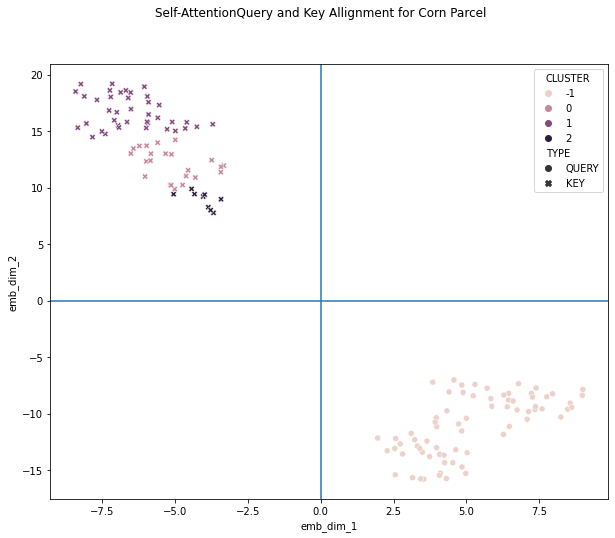

In [5]:
fig, axs = plt.subplots(figsize=(10, 8))
fig.suptitle("Self-AttentionQuery and Key Allignment for Corn Parcel")
ax_compatibility = sns.scatterplot(data=all_data, x="emb_dim_1", y="emb_dim_2", hue = "CLUSTER", style="TYPE", ax = axs)
ax_compatibility.axhline(0.0)
ax_compatibility.axvline(0.0)
for idx in most_common_keys_indices:
    query_idx = idx
    key_idx = idx + len(valid_positions)
    #ax_compatibility.text(all_data.iloc[query_idx]["emb_dim_1"], all_data.iloc[query_idx]["emb_dim_2"], all_data.index[query_idx])
    #ax_compatibility.text(all_data.iloc[key_idx]["emb_dim_1"], all_data.iloc[key_idx]["emb_dim_2"], all_data.index[key_idx])